# Void Tracking
Demonstration of how to use the void tracking utilities

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from rtdefects.analysis import convert_to_per_particle, compile_void_tracks, compute_drift
import trackpy as tp
import pandas as pd
import numpy as np

## Load in the defect information
The `rtdefects` command-line application generates a JSON file with the positions and sizes of each void detected in each frame.

Our first step is to load that JSON into memory

In [2]:
void_data = pd.read_json('files/video34-Ni-600C-then-650C_defects.json', lines=True).sort_values("image-path", ignore_index=True)
print(f'Loaded defects from {len(void_data)} frames')

Loaded defects from 1477 frames


## Show that we've detected void growth
Without tracking individual voids, we can see that they are growing in size and number

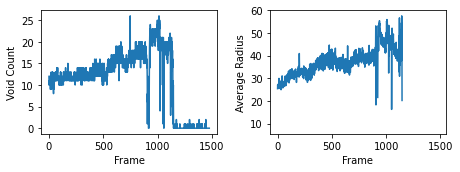

In [3]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(6.5, 2.5))

axs[0].plot(void_data.index, void_data['void_count'])
axs[0].set_ylabel('Void Count')

axs[1].plot(void_data.index, void_data['radii_average'])
axs[1].set_ylabel('Average Radius')

for ax in axs:
    ax.set_xlabel('Frame')
    
fig.tight_layout()

We can see that we are detecting at least a dozen void per frame. Both the number and size increase with time.

There are many frames at the end where we don't detect any defects. Let's eliminate thsoe from the analysis.

In [4]:
void_data.query('void_count > 0', inplace=True, )
print(f'Reduced to {len(void_data)} frames with at least 1 void.')

Reduced to 1166 frames with at least 1 void.


## Do an initial pass of defect detection
We are going to get the positions of the slow-moving voids to detect the drift between frames

In [5]:
%%time
particles = pd.concat(list(convert_to_per_particle(void_data)))
initial_tracks = tp.link_df(particles, search_range=10, memory=3)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles')

Frame 1444: 2 trajectories present.
Found a total of 2735 unique particles
CPU times: user 1.55 s, sys: 126 ms, total: 1.68 s
Wall time: 1.55 s


Let's plot the tracks of a few

In [6]:
void_tracks = compile_void_tracks(initial_tracks)
void_tracks.sort_values('total_frames').tail(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
142,201,476,276,0,"[[392.9471974004874, 554.6677497969131], [393....","[0.0, 0.06457629442605488, 1.1946113749989995,...",84.003790,0.304362,"[0.0, 0.06457629442605488, 1.1998808938837642,...",243.120680,0.880872,"[39.58987092134787, 39.299358363257696, 40.354...",48.494056,39.299358,0.028160
140,201,476,276,0,"[[108.07837648705389, 98.36109167249825], [107...","[0.0, 0.6414840198402811, 0.8403738881099015, ...",85.283419,0.308998,"[0.0, 0.6414840198402811, 0.9886338716132734, ...",255.619951,0.926159,"[42.65512055341712, 41.274623085567335, 41.551...",59.108115,40.964982,0.025597


(0.0, 1024.0)

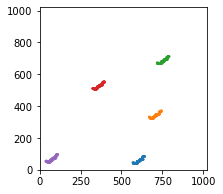

In [7]:
fig, ax = plt.subplots(figsize=(3, 3))

longest_tracks = void_tracks.sort_values('total_frames').tail(5)
for pos in longest_tracks['positions']:
    ax.plot(pos[:, 0], pos[:, 1], ':o', ms=1)

ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)

We can see a systematic trend with all of the voids "moving" the same direction, which we can attribute to image drift.

## Removing Drift
We detect drift from the median movement of all voids over each frame.

In [8]:
drift = compute_drift(initial_tracks)

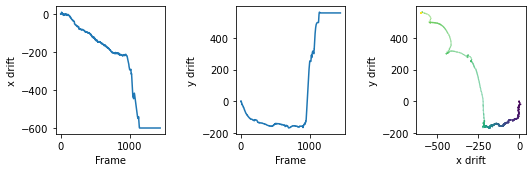

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, [0, 1], ['x', 'y']):
    ax.plot(drift[:, i])
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(drift[:, 0], drift[:, 1], c=np.arange(drift.shape[0]), s=0.1)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

fig.tight_layout()

We can see there are two distinct phases of drift. We gradually move to the lower left and then to the upper left.

Given these drifts, let's re-evaluate the positions of each void

In [10]:
initial_tracks['x'] -= drift[initial_tracks['frame'], 0]

In [11]:
initial_tracks['y'] -= drift[initial_tracks['frame'], 1]

In [12]:
void_tracks = compile_void_tracks(initial_tracks)
void_tracks.sort_values('total_frames').tail(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
142,201,476,276,0,"[[444.6391925280859, 671.641087040753], [444.6...","[0.0, 0.3590734365196866, 0.6441576927100313, ...",8.291997,0.030043,"[0.0, 0.3590734365196866, 1.19165271208916, 2....",120.737975,0.437456,"[39.58987092134787, 39.299358363257696, 40.354...",48.494056,39.299358,0.028160
140,201,476,276,0,"[[159.7703716146524, 215.33442891633814], [159...","[0.0, 0.3852442596221657, 0.3301480401124719, ...",6.343393,0.022983,"[0.0, 0.3852442596221657, 0.44972502660385416,...",130.877783,0.474195,"[42.65512055341712, 41.274623085567335, 41.551...",59.108115,40.964982,0.025597


(0.0, 1024.0)

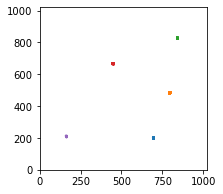

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))

longest_tracks = void_tracks.sort_values('total_frames').tail(5)
for pos in longest_tracks['positions']:
    ax.plot(pos[:, 0], pos[:, 1], ':o', ms=1)

ax.set_xlim(0, 1024)
ax.set_ylim(0, 1024)

Note they are all mostly static

## Remove drift and then re-detect voids
Now that we know which movements are due to the microscope drift, we can be more confident in labeling voids.

In [14]:
particles['x'] -= drift[particles['frame'], 0]

In [15]:
particles['y'] -= drift[particles['frame'], 1]

In [16]:
%%time
initial_tracks = tp.link_df(particles, search_range=10, memory=3)
print(f'Found a total of {len(initial_tracks.particle.value_counts())} unique particles')

Frame 1444: 2 trajectories present.
Found a total of 2058 unique particles
CPU times: user 796 ms, sys: 155 ms, total: 951 ms
Wall time: 793 ms


Note how we fewer unique voids this time! Things that initially "moved" too far to detect because of the camera drift are now associated together.

In [17]:
void_tracks = compile_void_tracks(initial_tracks)
void_tracks

,start_frame,end_frame,total_frames,inferred_frames,positions,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,38,39,0,"[[6.161048689138576, 112.85393258426966], [6.0...","[0.0, 0.16575776316605317, 0.4066787096789729,...",4.544139,0.116516,"[0.0, 0.16575776316605317, 0.4552567819352688,...",33.833452,0.867524,"[18.437867513470433, 19.08262324195121, 19.281...",26.123866,14.668929,-0.095582
1,0,21,22,11,"[[27.875838926174495, 320.96644295302013], [28...","[0.0, 0.4221402471343445, 0.8442804942686543, ...",4.537920,0.206269,"[0.0, 0.4221402471343445, 0.8442804942686541, ...",27.256356,1.238925,"[19.47884453275087, 17.91530607784169, 16.3517...",19.478845,8.667245,0.092943
2,0,90,91,0,"[[89.68503937007874, 127.82114735658043], [89....","[0.0, 0.3471476922544422, 0.5807706435567195, ...",2.059030,0.022627,"[0.0, 0.3471476922544422, 0.6488045421373106, ...",55.972481,0.615082,"[33.64386950500135, 33.33973788969849, 34.0763...",38.629480,33.090573,0.046965
3,0,90,91,1,"[[121.0231884057971, 240.13333333333333], [121...","[0.0, 0.5659027784767252, 0.420591103996161, 0...",3.431565,0.037710,"[0.0, 0.5659027784767252, 0.774020499556609, 1...",79.955142,0.878628,"[20.958712816717327, 21.290215544369623, 21.90...",28.988586,19.049233,0.054568
4,0,90,91,0,"[[247.7584803256445, 398.57937584803256], [247...","[0.0, 0.5050488187505003, 0.5998002591927982, ...",1.515365,0.016652,"[0.0, 0.5050488187505003, 1.6093816456734817, ...",43.498973,0.478011,"[30.632948674096244, 29.70446102021492, 29.811...",36.072854,29.402885,0.055697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,1409,1409,1,0,"[[1263.3270458332372, -380.5164892181177]]",NaN,NaN,NaN,NaN,NaN,NaN,[15.957691216057308],15.957691,15.957691,NaN
2054,1434,1434,1,0,"[[710.5557958332371, -536.0260725514511]]",NaN,NaN,NaN,NaN,NaN,NaN,[11.055812783082736],11.055813,11.055813,NaN
2055,1441,1441,1,0,"[[1227.1947047927747, 20.382585926391016]]",NaN,NaN,NaN,NaN,NaN,NaN,[20.98906578384008],20.989066,20.989066,NaN
2056,1444,1444,1,0,"[[1296.5676013887928, -447.569822551451]]",NaN,NaN,NaN,NaN,NaN,NaN,[13.110581167104948],13.110581,13.110581,NaN


## Perform some analyzes
Show some key points we learn about the voids

(10.0, 60.0)

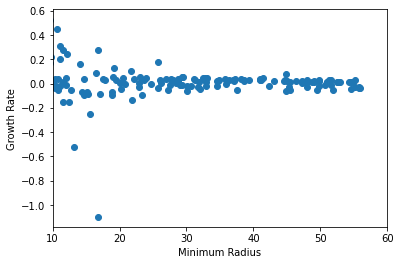

In [18]:
fig, ax = plt.subplots()
long_lived = void_tracks.query('total_frames > 15')

ax.scatter(long_lived['min_radius'], long_lived['growth_rate'])
ax.set_xlabel('Minimum Radius')
ax.set_ylabel('Growth Rate')

ax.set_xlim(10, 60)
#ax.set_ylim(-1, 1)

We have a partition between small voids that grow and disappear

Text(0, 0.5, 'Movement Rate')

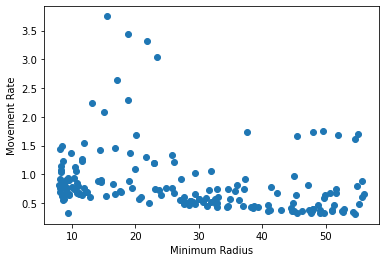

In [19]:
fig, ax = plt.subplots()

long_lived = void_tracks.query('total_frames > 15')

ax.scatter(long_lived['min_radius'], long_lived['movement_rate'])
ax.set_xlabel('Minimum Radius')
ax.set_ylabel('Movement Rate')

Small voids generally move farther than larger ones

In [20]:
void_tracks.to_csv('void_tracks.csv', index=False)